### Install packages for notebook

In [1]:
!pip install openfisca-core==25.2.2 >> /dev/null
!pip install openfisca-france==32.3.0 >> /dev/null
!pip install matplotlib >> /dev/null
!pip install mpld3 >> /dev/null
!pip install pandas >> /dev/null
!pip install seaborn >> /dev/null

/bin/sh: pip: command not found
/bin/sh: pip: command not found
/bin/sh: pip: command not found
/bin/sh: pip: command not found
/bin/sh: pip: command not found


In [2]:
%matplotlib inline

In [3]:
import matplotlib
import matplotlib.pyplot as plt, mpld3
from matplotlib.ticker import FuncFormatter
from mpld3 import plugins
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', 250)
pd.set_option('precision', 0)

In [4]:
#Specific usage imports
from openfisca_core import periods, rates
from openfisca_core.tools import get_trace_tool_link
import openfisca_france

libyaml is not installed in your environment. This can make OpenFisca slower to start. Once you have installed libyaml, run 'pip uninstall pyyaml && pip install pyyaml --no-cache-dir' so that it is used in your Python environment.



In [5]:
tax_benefit_system = openfisca_france.FranceTaxBenefitSystem()

In [6]:
ax_variable_max = 280000
count = 1000

year_lag_max = 4
def make_scenario(couple = True, mar_pacs = True, nombre_enfants = 0, year = None, tax_benefit_system = tax_benefit_system,
                                    axes_variable = 'salaire_de_base',  ax_variable_max = ax_variable_max, ax_variable_min = 0,
                                    count = count,count_span = None, age = 12, salaire_de_base_conjoint = 0):
    if mar_pacs: assert couple == True
    if count is None: count =  (ax_variable_max - ax_variable_min)/count_span #Fais une simulation par tranche de 10 euros brut
    
    enfant = [dict(age = age)]
    enfants = enfant * nombre_enfants
    
    scenario = tax_benefit_system.new_scenario().init_single_entity(
        axes = [
            [dict(count = count, 
                  min = ax_variable_min,
                  max = ax_variable_max,
                  name = axes_variable,
                  period = year-fill_lag) for fill_lag in range(year_lag_max)]
            ],
        period = year,
        parent1 = dict(
            age = 40,
            ppe_du_sa = 6020,
            statut_marital = u"pacse",
            ) if mar_pacs else dict(
            age = 40,
            ppe_du_sa = 6020, statut_marital = u"celibataire" 
            ),
        parent2 = dict(age = 40,ppe_du_sa = 6020,statut_marital = "pacse", salaire_de_base = salaire_de_base_conjoint) if mar_pacs else (dict(age = 40,ppe_du_sa = 6020,salaire_de_base = salaire_de_base_conjoint, statut_marital = u"celibataire") if couple == True else None) ,
        enfants = enfants,
        menage = dict(
            loyer = 12000,
            statut_occupation_logement = "locataire_vide",
            depcom = 13012,
            ),
        foyer_fiscal = dict(
            f7ea = nombre_enfants * ((age<15) * age>=11), #Nombre enfants à charge poursuivants leurs études : collège
            f7ec = nombre_enfants * ((age<19) * age>=15), #Nombre enfants à charge poursuivants leurs études : lycée
            f7ef = nombre_enfants * ((age<26) * age>=19), #Nombre enfants à charge poursuivants leurs études : Enseignement supérieur
            caseT = False if couple == True else True * (nombre_enfants>0)# Warning ! TODO: mieux gérer, à priori pose pas de problème si True avec un couple marié...
            ),
        )

    if (couple == True) and (mar_pacs==False):
        test_case = scenario.test_case
        test_case["foyers_fiscaux"][0]['declarants']  = ['ind0']
        test_case["foyers_fiscaux"].append({'declarants': ['ind1'],'id': 1,'caseT': False })
        scenario.test_case = test_case
        return scenario
    else:
        return scenario
        
        


## The French income tax scheme



A piecewize linear tax scheme is defined as: 
1. A sequence of (usually) increasing marginal tax rates,  
$$0<m_0 <m_1 <...<m_p$$

2. A sequence of thresholds specifying the bands of taxable income to which the respective rates applies:

$$0= \beta_0<\beta_1< ... < \beta_n  $$


If $y \in [\beta_k,\beta_{k+1}]$, then the tax liability is :  
$$s(y)=   \sum_{j \leq k-1} mj(\beta{j+1} − \beta{j})+m_k(y−\beta_j)$$

<p><center>
Where $y$ is the household taxable income.  
    
(Formalisation taken in P.J. "Lambert The distribution and redistribution of income", third edition P.181)</center></p>

#### Tax brackets in 2011

In [7]:
year = 2011
empty_simulation = tax_benefit_system.new_scenario().new_simulation()
df = pd.DataFrame()
parameters = empty_simulation.tax_benefit_system.parameters(periods.period(year))
df["Rate ($m$)"] = pd.Series(parameters.impot_revenu.bareme.rates)
df["Threshold ($\\beta$)"] = pd.Series(parameters.impot_revenu.bareme.thresholds)
pd.options.display.float_format = '{:20,.10g}'.format


df_piecewize_scheame = df
df_piecewize_scheame.dropna(axis=0, how='all', inplace = True) ; df_piecewize_scheame.replace(np.nan, "")#.style.set_properties(**{'text-align': 'right'})

,Rate ($m$),Threshold ($\beta$)
0,0,0
1,0.055,"5,963"
2,0.14,"11,896"
3,0.3,"26,420"
4,0.41,"70,830"


The above table gives the marginal tax rates and thresholds of the French income tax scheme in 2011. OpenFisca 2011 base year account for the income tax 2012 on income 2011.

##### Exemple:  
We are going to generate a simulation for a single. We vary the income, and the number of children for different years.


In [8]:
## Simulations for single.
simulation_dict_single = dict()
for nb_enf in range(0,6):
    simulation_dict_single[nb_enf] = dict()
    for year in range(2010,2016): 
        simulation_dict_single[nb_enf][year] = make_scenario(couple = False, mar_pacs=False, nombre_enfants=nb_enf,year = year, count=1000).new_simulation()

But for now we focus on fiscal-households without children...

(0, 40000)

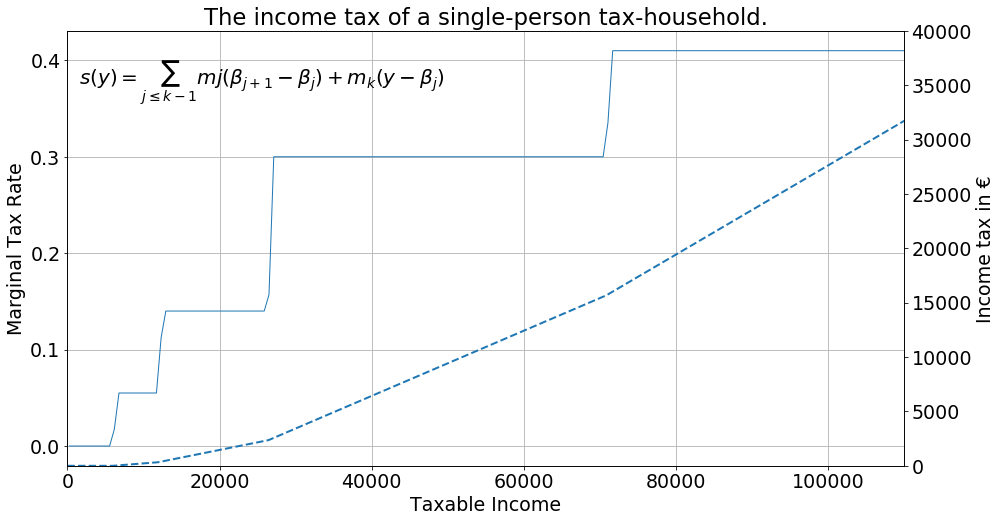

In [9]:
matplotlib.rc('font', size=19)
fig, ax1 = plt.subplots(figsize=(15,8))
ax2 = ax1.twinx()
smooth = 3
ax1.grid()

for year in [2011]: 

    for nb_enf in [0]:
        keep = ax1.plot(simulation_dict_single[nb_enf][year].calculate_add("rbg",year)[::smooth][1:],
                1 -rates.marginal_rate(simulation_dict_single[nb_enf][year].calculate_add("ir_plaf_qf",year)[::smooth],
                   simulation_dict_single[nb_enf][year].calculate_add("rbg",year)[::smooth]),  
                 linewidth = 1)
        ax2.plot(simulation_dict_single[nb_enf][year].calculate_add("rbg",year),
               simulation_dict_single[nb_enf][year].calculate_add("ir_plaf_qf",year), 
                 linewidth = 2, color = keep[0].get_color(), linestyle = "--")
plt.text(1500,35000,r"$s(y)=   \sum_{j \leq k-1} mj(\beta_{j+1}- \beta_{j})+m_k (y -\beta_j) $", fontsize = 20)     

ax1.set_xlabel("Taxable Income")
ax1.set_ylabel("Marginal Tax Rate"); ax2.set_ylabel(u"Income tax in €")
plt.title("The income tax of a single-person tax-household.")
plt.xlim(0, 110_000); ax2.set_ylim(0, 40_000)

The graph above shows the marginal tax rate (left axis, plain line) for a given taxable income, and the income tax (dashed line, right axis) in euros.  
We clearly see the 5 brackets marginal tax scheme that corresponds to the previous table.

#### The family quotient (le quotient familial).

On top of the piecewize linear tax scheme, there exists a specific mechanism called called the family quotient created for horizontal equity purposes.   


Each tax-household has a certain number of fiscal shares based on family composition.

It consist of dividing the tax base by the number of fiscal shares, then apply the piecewise income tax scheme:

<h4><center>$s(\frac{y}{\text{Fiscal Shares}}) \times \text{Fiscal Shares} $  </center></h4>



The consequence of such a mechanism is that the lenght of each marginal tax bracket is widened by the number of fiscal shares times.

##### Exemple:  
We are going to generate a simulation for married couples. We vary the income, and the number of children for different years.


In [10]:
## Simulation for couples.
simulation_dict = dict()
for nb_enf in range(0,7):
    simulation_dict[nb_enf] = dict()
    for year in range(2007,2016): 
        simulation_dict[nb_enf][year] = make_scenario(couple = True,mar_pacs=True,nombre_enfants=nb_enf,year = year, count= 1000).new_simulation()

But for now we focus on couples without children...



A single has <b>1</b> fiscal share, a couple has <b>2</b> fiscal shares. We compare the income tax of a single-person tax household and a married tax-household.

(0, 200000)

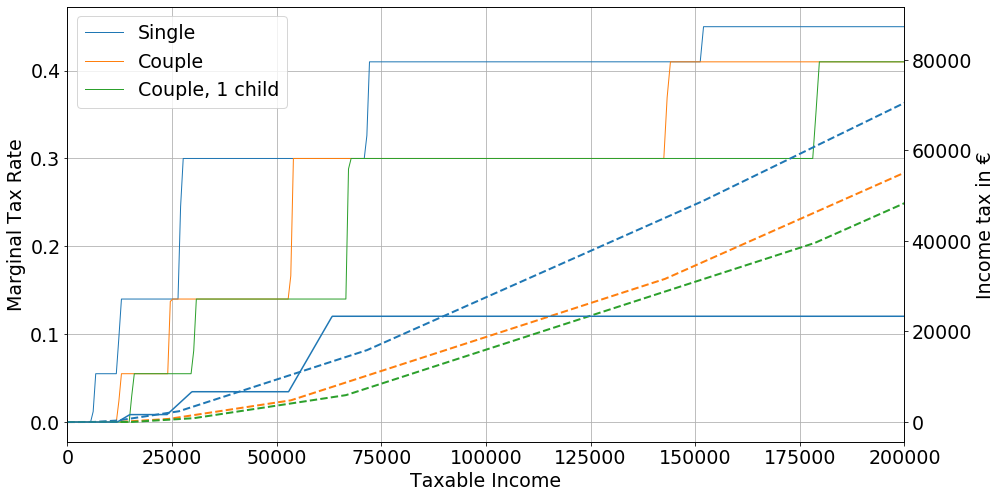

In [11]:
matplotlib.rc('font', size=19)
fig, ax1 = plt.subplots(figsize=(15,8))
ax2 = ax1.twinx()
smooth = 3
nb_enf = 0


 
#plt.legend(fontsize = 15, loc = 2)
#plt.ylim((0,.45))
ax1.grid()



for year in [2013]: 

    for nb_enf in [0]:
        keep = ax1.plot(simulation_dict_single[nb_enf][year].calculate_add("rbg",year)[::smooth][1:],
                1 -rates.marginal_rate(simulation_dict_single[nb_enf][year].calculate_add("ir_brut",year)[::smooth],
                   simulation_dict_single[nb_enf][year].calculate_add("rbg",year)[::smooth]),  
                  label = "Single".format(year, nb_enf),
                 linewidth = 1)
        ax2.plot(simulation_dict_single[nb_enf][year].calculate_add("rbg",year),
               simulation_dict_single[nb_enf][year].calculate_add("ir_brut",year), 
                 linewidth = 2, color = keep[0].get_color(), linestyle = "--")
        
        
        keep = ax1.plot(simulation_dict[nb_enf][year].calculate_add("rbg",year)[::smooth][1:],
                1 -rates.marginal_rate(simulation_dict[nb_enf][year].calculate_add("ir_brut",year)[::smooth],
                   simulation_dict[nb_enf][year].calculate_add("rbg",year)[::smooth]),  
                  label = "Couple".format(year, nb_enf),
                 linewidth = 1)
        ax2.plot(simulation_dict[nb_enf][year].calculate_add("rbg",year),
               simulation_dict[nb_enf][year].calculate_add("ir_brut",year), 
                 linewidth = 2, color = keep[0].get_color(), linestyle = "--")
        
        
    for nb_enf in [1,]:

        keep =  ax1.plot(simulation_dict[nb_enf][year].calculate_add("rbg",year)[::smooth][1:],
                1 -rates.marginal_rate(simulation_dict[nb_enf][year].calculate_add("ir_brut",year)[::smooth],
                   simulation_dict[nb_enf][year].calculate_add("rbg",year)[::smooth]),  
                  label =  "Couple, {} child".format(nb_enf),
                 linewidth = 1)
        ax2.plot(simulation_dict[nb_enf][year].calculate_add("rbg",year),
               simulation_dict[nb_enf][year].calculate_add("ir_brut",year), 
                 linewidth = 2, color = keep[0].get_color(), linestyle = "--")
        
        ax2.plot(simulation_dict[1][2011].calculate("rbg", period = 2011),
            simulation_dict[1][2011].calculate("avantage_qf", period = 2011)*10)

ax1.set_xlabel("Taxable Income")
ax1.set_ylabel("Marginal Tax Rate"); ax2.set_ylabel(u"Income tax in €")
ax1.legend()
plt.xlim(0, 200000)

(0, 200000)

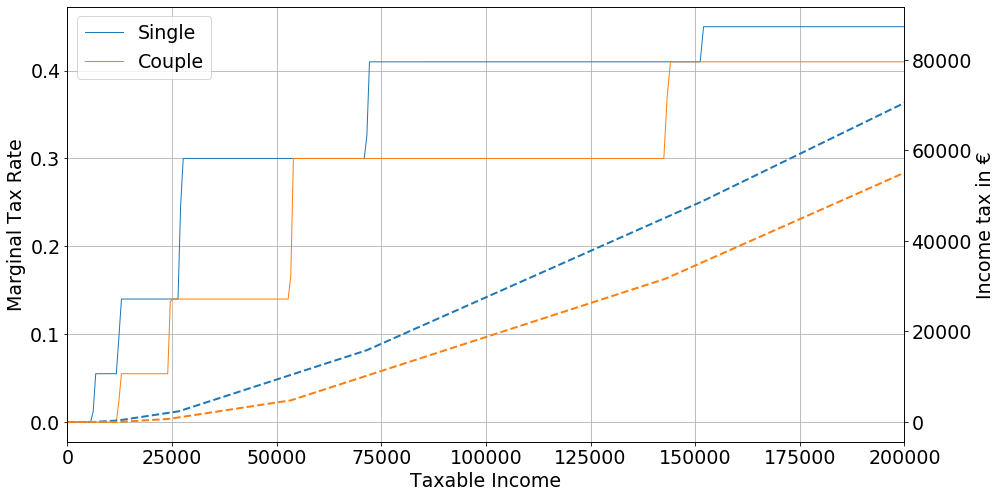

In [12]:
matplotlib.rc('font', size=19)
fig, ax1 = plt.subplots(figsize=(15,8))
ax2 = ax1.twinx()
smooth = 3
nb_enf = 0


 
#plt.legend(fontsize = 15, loc = 2)
#plt.ylim((0,.45))
ax1.grid()



for year in [2013]: 

    for nb_enf in [0]:
        keep = ax1.plot(simulation_dict_single[nb_enf][year].calculate_add("rbg",year)[::smooth][1:],
                1 -rates.marginal_rate(simulation_dict_single[nb_enf][year].calculate_add("ir_brut",year)[::smooth],
                   simulation_dict_single[nb_enf][year].calculate_add("rbg",year)[::smooth]),  
                  label = "Single".format(year, nb_enf),
                 linewidth = 1)
        ax2.plot(simulation_dict_single[nb_enf][year].calculate_add("rbg",year),
               simulation_dict_single[nb_enf][year].calculate_add("ir_brut",year), 
                 linewidth = 2, color = keep[0].get_color(), linestyle = "--")
        
        
        keep = ax1.plot(simulation_dict[nb_enf][year].calculate_add("rbg",year)[::smooth][1:],
                1 -rates.marginal_rate(simulation_dict[nb_enf][year].calculate_add("ir_brut",year)[::smooth],
                   simulation_dict[nb_enf][year].calculate_add("rbg",year)[::smooth]),  
                  label = "Couple".format(year, nb_enf),
                 linewidth = 1)
        ax2.plot(simulation_dict[nb_enf][year].calculate_add("rbg",year),
               simulation_dict[nb_enf][year].calculate_add("ir_brut",year), 
                 linewidth = 2, color = keep[0].get_color(), linestyle = "--")
        


ax1.set_xlabel("Taxable Income")
ax1.set_ylabel("Marginal Tax Rate"); ax2.set_ylabel(u"Income tax in €")
ax1.legend()
plt.xlim(0, 200000)

We see that each marginal tax bracket of the couple is two times larger than the one of the single.

(0, 200000)

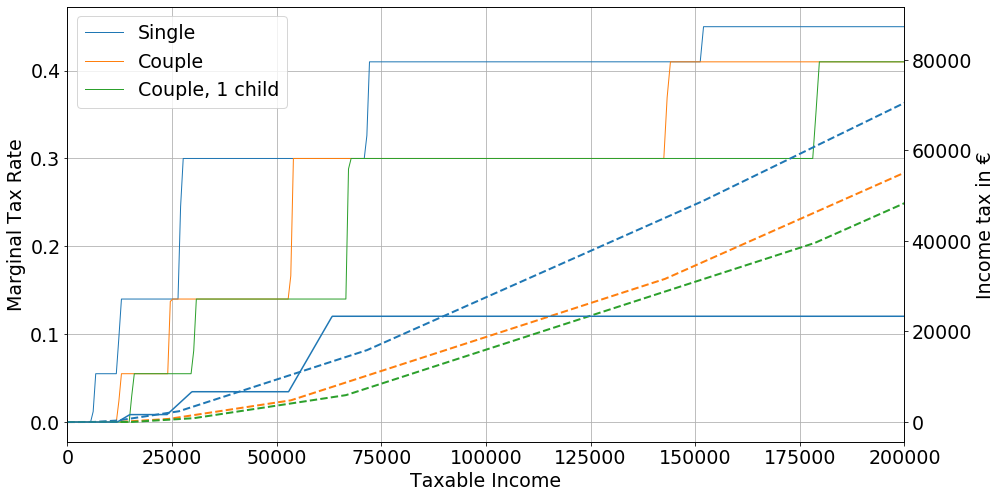

In [13]:
matplotlib.rc('font', size=19)
fig, ax1 = plt.subplots(figsize=(15,8))
ax2 = ax1.twinx()
smooth = 3
nb_enf = 0


 
#plt.legend(fontsize = 15, loc = 2)
#plt.ylim((0,.45))
ax1.grid()



for year in [2013]: 

    for nb_enf in [0]:
        keep = ax1.plot(simulation_dict_single[nb_enf][year].calculate_add("rbg",year)[::smooth][1:],
                1 -rates.marginal_rate(simulation_dict_single[nb_enf][year].calculate_add("ir_brut",year)[::smooth],
                   simulation_dict_single[nb_enf][year].calculate_add("rbg",year)[::smooth]),  
                  label = "Single".format(year, nb_enf),
                 linewidth = 1)
        ax2.plot(simulation_dict_single[nb_enf][year].calculate_add("rbg",year),
               simulation_dict_single[nb_enf][year].calculate_add("ir_brut",year), 
                 linewidth = 2, color = keep[0].get_color(), linestyle = "--")
        
        
        keep = ax1.plot(simulation_dict[nb_enf][year].calculate_add("rbg",year)[::smooth][1:],
                1 -rates.marginal_rate(simulation_dict[nb_enf][year].calculate_add("ir_brut",year)[::smooth],
                   simulation_dict[nb_enf][year].calculate_add("rbg",year)[::smooth]),  
                  label = "Couple".format(year, nb_enf),
                 linewidth = 1)
        ax2.plot(simulation_dict[nb_enf][year].calculate_add("rbg",year),
               simulation_dict[nb_enf][year].calculate_add("ir_brut",year), 
                 linewidth = 2, color = keep[0].get_color(), linestyle = "--")
        
        
    for nb_enf in [1,]:

        keep =  ax1.plot(simulation_dict[nb_enf][year].calculate_add("rbg",year)[::smooth][1:],
                1 -rates.marginal_rate(simulation_dict[nb_enf][year].calculate_add("ir_brut",year)[::smooth],
                   simulation_dict[nb_enf][year].calculate_add("rbg",year)[::smooth]),  
                  label =  "Couple, {} child".format(nb_enf),
                 linewidth = 1)
        ax2.plot(simulation_dict[nb_enf][year].calculate_add("rbg",year),
               simulation_dict[nb_enf][year].calculate_add("ir_brut",year), 
                 linewidth = 2, color = keep[0].get_color(), linestyle = "--")
        
        ax2.plot(simulation_dict[1][2011].calculate("rbg", period = 2011),
            simulation_dict[1][2011].calculate("avantage_qf", period = 2011)*10)

ax1.set_xlabel("Taxable Income")
ax1.set_ylabel("Marginal Tax Rate"); ax2.set_ylabel(u"Income tax in €")
ax1.legend()
plt.xlim(0, 200000)

(0, 10000)

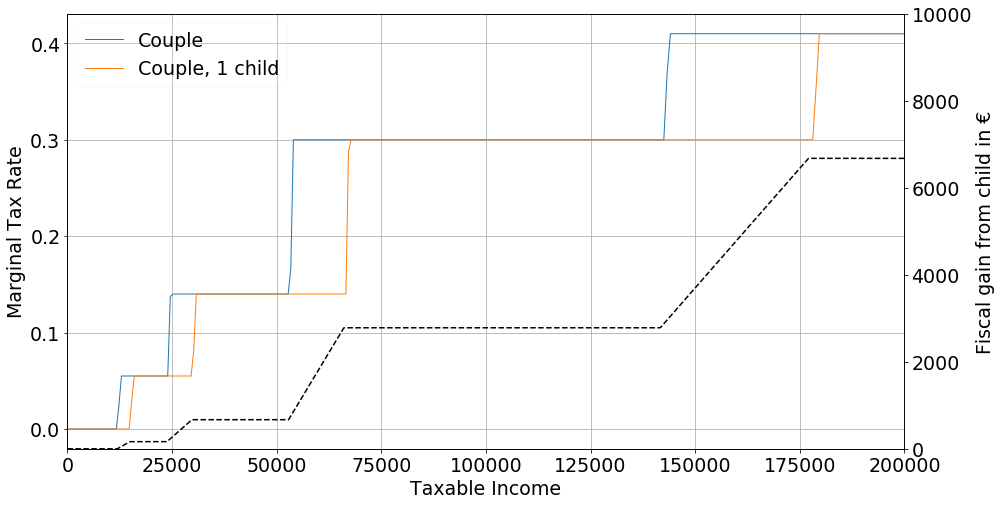

In [14]:
matplotlib.rc('font', size=19)
fig, ax1 = plt.subplots(figsize=(15,8))
ax2 = ax1.twinx()
smooth = 3
nb_enf = 0


 
#plt.legend(fontsize = 15, loc = 2)
#plt.ylim((0,.45))
ax1.grid()



for year in [2013]: 

    for nb_enf in [0]:

        
        keep = ax1.plot(simulation_dict[nb_enf][year].calculate_add("rbg",year)[::smooth][1:],
                1 -rates.marginal_rate(simulation_dict[nb_enf][year].calculate_add("ir_brut",year)[::smooth],
                   simulation_dict[nb_enf][year].calculate_add("rbg",year)[::smooth]),  
                  label = "Couple".format(year, nb_enf),
                 linewidth = 1)

        
    for nb_enf in [1,]:

        keep =  ax1.plot(simulation_dict[nb_enf][year].calculate_add("rbg",year)[::smooth][1:],
                1 -rates.marginal_rate(simulation_dict[nb_enf][year].calculate_add("ir_brut",year)[::smooth],
                   simulation_dict[nb_enf][year].calculate_add("rbg",year)[::smooth]),  
                  label =  "Couple, {} child".format(nb_enf),
                 linewidth = 1)


        
        ax2.plot(simulation_dict[1][2011].calculate("rbg", period = 2011),
            simulation_dict[0][2011].calculate("ir_brut", period = 2011) - simulation_dict[1][2011].calculate("ir_brut", period = 2011),
                color = "k", linestyle = "--")
        

        


ax1.set_xlabel("Taxable Income")
ax1.set_ylabel("Marginal Tax Rate"); ax2.set_ylabel(u"Fiscal gain from child in €")
ax1.legend(loc = 2, framealpha = 0.1)
plt.xlim(0, 200000)
ax2.set_ylim(0,10000)

(0, 10000)

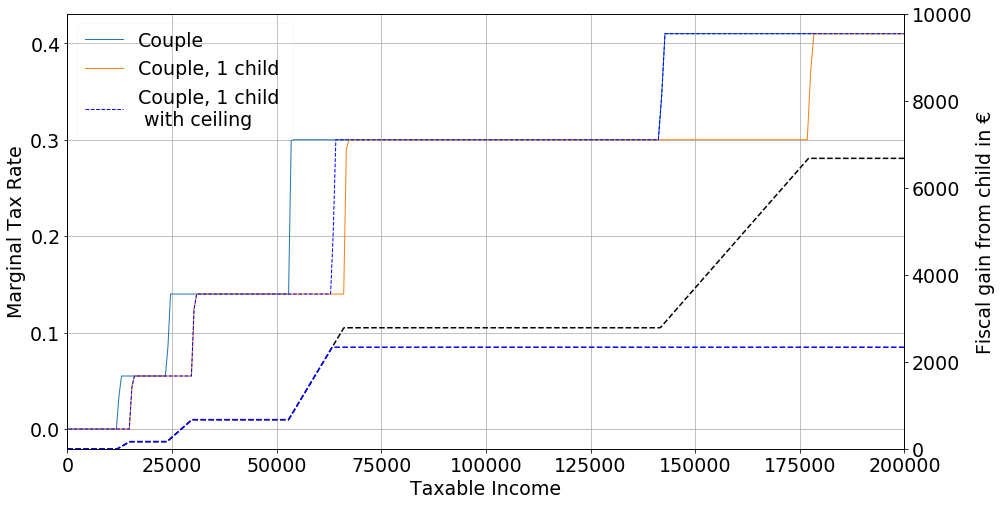

In [15]:
matplotlib.rc('font', size=19)
fig, ax1 = plt.subplots(figsize=(15,8))
ax2 = ax1.twinx()
smooth = 3
nb_enf = 0


 
#plt.legend(fontsize = 15, loc = 2)
#plt.ylim((0,.45))
ax1.grid()



for year in [2011]: 

    for nb_enf in [0]:

        
        keep = ax1.plot(simulation_dict[nb_enf][year].calculate_add("rbg",year)[::smooth][1:],
                1 -rates.marginal_rate(simulation_dict[nb_enf][year].calculate_add("ir_brut",year)[::smooth],
                   simulation_dict[nb_enf][year].calculate_add("rbg",year)[::smooth]),  
                  label = "Couple".format(year, nb_enf),
                 linewidth = 1)

        
    for nb_enf in [1,]:

        keep =  ax1.plot(simulation_dict[nb_enf][year].calculate_add("rbg",year)[::smooth][1:],
                1 -rates.marginal_rate(simulation_dict[nb_enf][year].calculate_add("ir_brut",year)[::smooth],
                   simulation_dict[nb_enf][year].calculate_add("rbg",year)[::smooth]),  
                  label =  "Couple, {} child".format(nb_enf),
                 linewidth = 1)
        ax1.plot(simulation_dict[nb_enf][year].calculate_add("rbg",year)[::smooth][1:],
                1 -rates.marginal_rate(simulation_dict[nb_enf][year].calculate_add("ir_plaf_qf",year)[::smooth],
                   simulation_dict[nb_enf][year].calculate_add("rbg",year)[::smooth]),  
                  label =  "Couple, {} child \n with ceiling".format(nb_enf),
                 linewidth = 1, color = "b", linestyle = "--")


        
        ax2.plot(simulation_dict[1][2011].calculate("rbg", period = 2011),
            simulation_dict[0][2011].calculate("ir_brut", period = 2011) - simulation_dict[1][2011].calculate("ir_brut", period = 2011),
                color = "k", linestyle = "--")
        ax2.plot(simulation_dict[1][2011].calculate("rbg", period = 2011),
            simulation_dict[1][2011].calculate("avantage_qf", period = 2011), color = "b", linestyle = "--")

        


ax1.set_xlabel("Taxable Income")
ax1.set_ylabel("Marginal Tax Rate"); ax2.set_ylabel(u"Fiscal gain from child in €")
ax1.legend(loc = 2, framealpha = 0.1)
plt.xlim(0, 200000)
ax2.set_ylim(0,10000)

(0, 10000)

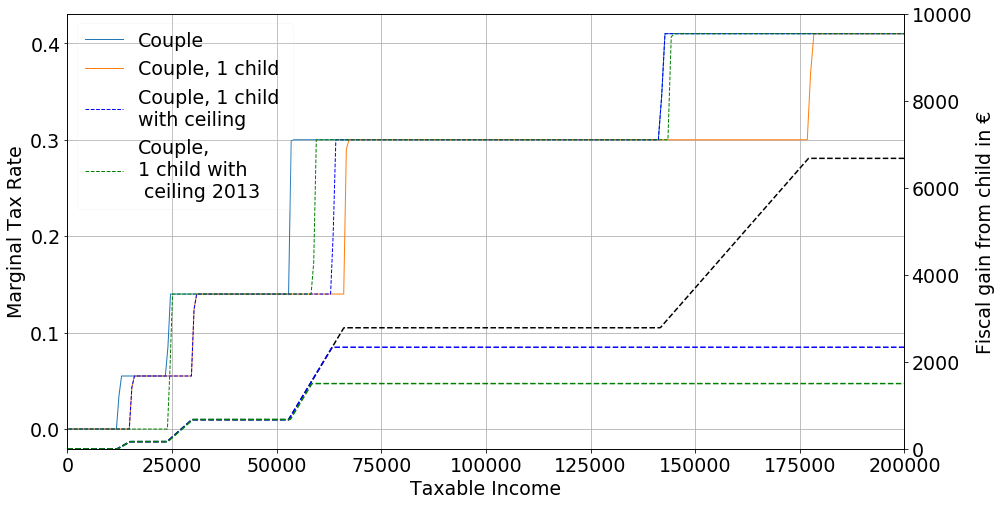

In [16]:
matplotlib.rc('font', size=19)
fig, ax1 = plt.subplots(figsize=(15,8))
ax2 = ax1.twinx()
smooth = 3
nb_enf = 0


 
#plt.legend(fontsize = 15, loc = 2)
#plt.ylim((0,.45))
ax1.grid()



for year in [2011]: 

    for nb_enf in [0]:

        
        keep = ax1.plot(simulation_dict[nb_enf][year].calculate_add("rbg",year)[::smooth][1:],
                1 -rates.marginal_rate(simulation_dict[nb_enf][year].calculate_add("ir_brut",year)[::smooth],
                   simulation_dict[nb_enf][year].calculate_add("rbg",year)[::smooth]),  
                  label = "Couple".format(year, nb_enf),
                 linewidth = 1)

        
    for nb_enf in [1,]:

        keep =  ax1.plot(simulation_dict[nb_enf][year].calculate_add("rbg",year)[::smooth][1:],
                1 -rates.marginal_rate(simulation_dict[nb_enf][year].calculate_add("ir_brut",year)[::smooth],
                   simulation_dict[nb_enf][year].calculate_add("rbg",year)[::smooth]),  
                  label =  "Couple, {} child".format(nb_enf),
                 linewidth = 1)
        ax1.plot(simulation_dict[nb_enf][year].calculate_add("rbg",year)[::smooth][1:],
                1 -rates.marginal_rate(simulation_dict[nb_enf][year].calculate_add("ir_plaf_qf",year)[::smooth],
                   simulation_dict[nb_enf][year].calculate_add("rbg",year)[::smooth]),  
                  label =  "Couple, {} child \nwith ceiling".format(nb_enf),
                 linewidth = 1, color = "b", linestyle = "--")
        

        ax1.plot(simulation_dict[nb_enf][2014].calculate_add("rbg",2014)[::smooth][1:],
                1 -rates.marginal_rate(simulation_dict[nb_enf][2014].calculate_add("ir_plaf_qf",2014)[::smooth],
                   simulation_dict[nb_enf][2014].calculate_add("rbg",2014)[::smooth]),  
                  label =  "Couple,\n{} child with\n ceiling 2013".format(nb_enf),
                 linewidth = 1, color = "g", linestyle = "--")

        
        ax2.plot(simulation_dict[1][2011].calculate("rbg", period = 2011),
            simulation_dict[0][2011].calculate("ir_brut", period = 2011) - simulation_dict[1][2011].calculate("ir_brut", period = 2011),
                color = "k", linestyle = "--")
        ax2.plot(simulation_dict[1][2011].calculate("rbg", period = 2011),
            simulation_dict[1][2011].calculate("avantage_qf", period = 2011), color = "b", linestyle = "--") 
        ax2.plot(simulation_dict[1][2013].calculate("rbg", period = 2013),
            simulation_dict[1][2013].calculate("avantage_qf", period = 2013), color = "g", linestyle = "--") 

ax1.set_xlabel("Taxable Income")
ax1.set_ylabel("Marginal Tax Rate"); ax2.set_ylabel(u"Fiscal gain from child in €")
ax1.legend(loc = 2, framealpha = 0.1)
plt.xlim(0, 200000)
ax2.set_ylim(0,10000)

(0, 200000)

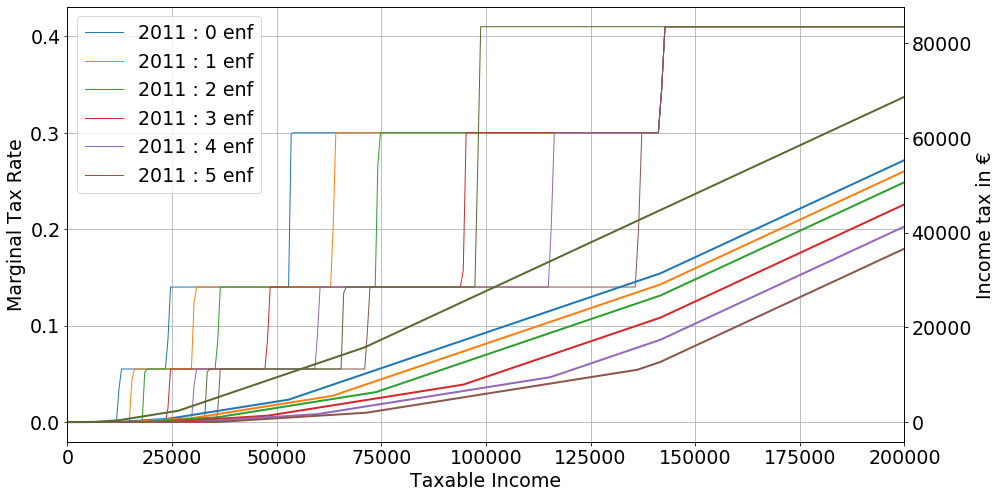

In [17]:
matplotlib.rc('font', size=19)
fig, ax1 = plt.subplots(figsize=(15,8))
ax2 = ax1.twinx()
smooth = 3
nb_enf = 0


 
#plt.legend(fontsize = 15, loc = 2)
#plt.ylim((0,.45))
ax1.grid()



for year in [2011]: 

    for nb_enf in range(0,6):
        ax1.plot(simulation_dict[nb_enf][year].calculate_add("rbg",year)[::smooth][1:],
                1 -rates.marginal_rate(simulation_dict[nb_enf][year].calculate_add("ir_plaf_qf",year)[::smooth],
                   simulation_dict[nb_enf][year].calculate_add("rbg",year)[::smooth]), 
                 label = "{} : {} enf".format(year, nb_enf), 
                 linewidth = 1, )
        ax2.plot(simulation_dict[nb_enf][year].calculate_add("rbg",year),
               simulation_dict[nb_enf][year].calculate_add("ir_plaf_qf",year), 
                 linewidth = 2, )


ax1.plot(simulation_dict_single[0][year].calculate_add("rbg",year)[::smooth][1:],
        1 -rates.marginal_rate(simulation_dict_single[nb_enf][year].calculate_add("ir_plaf_qf",year)[::smooth],
           simulation_dict_single[0][year].calculate_add("rbg",year)[::smooth]),  
         linewidth = 1, color = 'darkolivegreen')
ax2.plot(simulation_dict_single[0][year].calculate_add("rbg",year),
       simulation_dict_single[0][year].calculate_add("ir_plaf_qf",year), 
         linewidth = 2, color = 'darkolivegreen')
        

        

ax1.legend()
ax1.set_xlabel("Taxable Income")
ax1.set_ylabel("Marginal Tax Rate"); ax2.set_ylabel(u"Income tax in €")

plt.xlim(0, 200000)

In [18]:
# We just give the previous piecewise scheme table but with thresholds multiplied by two for the couple.
df = pd.DataFrame(index = range(40), columns= pd.MultiIndex.from_product([["Single", "Couple"], ["Rate ($m$)", "Threshold ($\\beta$)"]]))
df.loc[:, ("Single","Rate ($m$)")] = df_piecewize_scheame["Rate ($m$)"]; df.loc[:, ("Couple","Rate ($m$)")] = df_piecewize_scheame["Rate ($m$)"]
df.loc[:, ("Single","Threshold ($\\beta$)")] = df_piecewize_scheame["Threshold ($\\beta$)"]

df.loc[:, ("Couple","Threshold ($\\beta$)")] = df_piecewize_scheame["Threshold ($\\beta$)"]*2

df.dropna(axis=0, how='all').replace(np.nan, "")

Single                                    Couple  \
            Rate ($m$)  Threshold ($\beta$)           Rate ($m$)   
0                    0                    0                    0   
1                0.055                5,963                0.055   
2                 0.14               11,896                 0.14   
3                  0.3               26,420                  0.3   
4                 0.41               70,830                 0.41   

                        
   Threshold ($\beta$)  
0                    0  
1               11,926  
2               23,792  
3               52,840  
4              141,660

#### Number of fiscal shares based on family composition 

In [19]:
df = pd.DataFrame(index = range(6))
for nb_enf in range(0, 6):
    df.loc[nb_enf,u"Married couples"] = simulation_dict[nb_enf][2011].calculate("nbptr", period = "2011")[0]
    pd.options.display.float_format = '{:20,.10g}'.format
    df.index.name = "Number of Children"
df

,Married couples
Number of Children,
0,2
1,2.5
2,3
3,4
4,5
5,6


The above table gives the number of fiscal share for married couples based  on the number of children in the tax-household. It has not changed since 1980.

#### Fiscal advantage derived from children due to the family quotient.

As tax brackets of a couple will be 2 times larger than the one of a single-person, tax brackets of a family with two children will be $\frac{4}{2}= 2$ times larger than the one of a couple without children. Indeed a married couple with 3 child will have 4 fiscal shares while a married couple without children will have 2 fiscal shares.

(0, 200000)

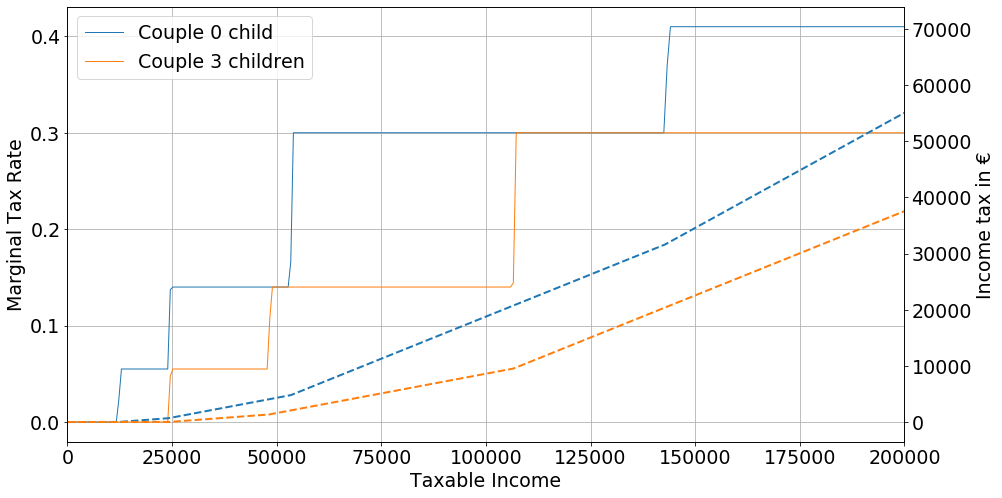

In [20]:
matplotlib.rc('font', size=19)
fig, ax1 = plt.subplots(figsize=(15,8))
ax2 = ax1.twinx()
smooth = 3
nb_enf = 0

ax1.grid()



for year in [2013]: 

    for nb_enf in [0,3]:
        keep = ax1.plot(simulation_dict[nb_enf][year].calculate_add("rbg",year)[::smooth][1:],
                1 -rates.marginal_rate(simulation_dict[nb_enf][year].calculate_add("ir_brut",year)[::smooth],
                   simulation_dict[nb_enf][year].calculate_add("rbg",year)[::smooth]),  
                  label = "Couple {} child{}".format(nb_enf,"ren"*(nb_enf>1)),
                 linewidth = 1)
        ax2.plot(simulation_dict[nb_enf][year].calculate_add("rbg",year),
               simulation_dict[nb_enf][year].calculate_add("ir_brut",year), 
                 linewidth = 2, color = keep[0].get_color(), linestyle = "--")
        


ax1.set_xlabel("Taxable Income")
ax1.set_ylabel("Marginal Tax Rate"); ax2.set_ylabel(u"Income tax in €")
ax1.legend()
plt.xlim(0, 200000)

Since the total income tax (dashed lines) is the integral of the MTR, the fiscal gain derived from children is the area between the two MTR curves.

(0, 20000)

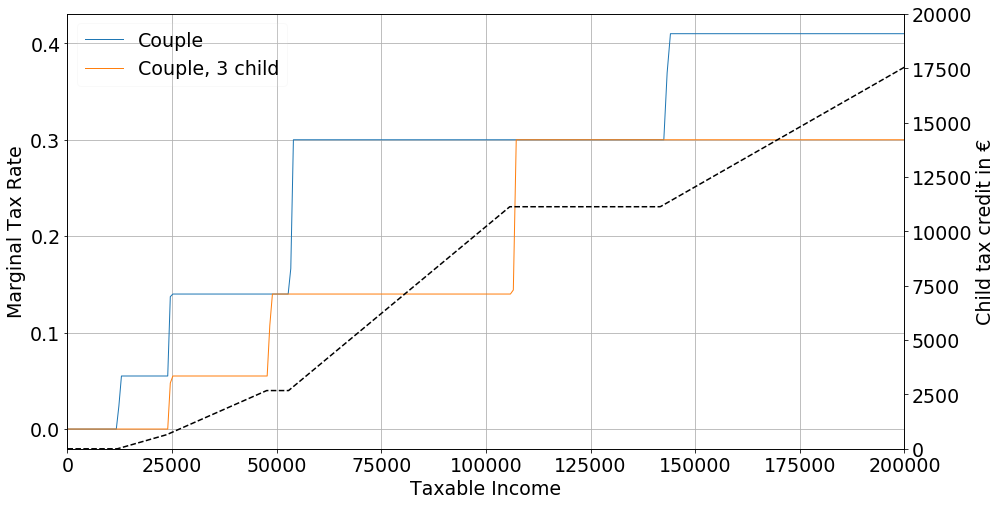

In [21]:
matplotlib.rc('font', size=19)
fig, ax1 = plt.subplots(figsize=(15,8))
ax2 = ax1.twinx()
smooth = 3
nb_enf = 0


 
#plt.legend(fontsize = 15, loc = 2)
#plt.ylim((0,.45))
ax1.grid()



for year in [2013]: 

    for nb_enf in [0]:

        
        keep = ax1.plot(simulation_dict[nb_enf][year].calculate_add("rbg",year)[::smooth][1:],
                1 -rates.marginal_rate(simulation_dict[nb_enf][year].calculate_add("ir_brut",year)[::smooth],
                   simulation_dict[nb_enf][year].calculate_add("rbg",year)[::smooth]),  
                  label = "Couple".format(year, nb_enf),
                 linewidth = 1)

        
    for nb_enf in [3,]:

        keep =  ax1.plot(simulation_dict[nb_enf][year].calculate_add("rbg",year)[::smooth][1:],
                1 -rates.marginal_rate(simulation_dict[nb_enf][year].calculate_add("ir_brut",year)[::smooth],
                   simulation_dict[nb_enf][year].calculate_add("rbg",year)[::smooth]),  
                  label =  "Couple, {} child".format(nb_enf),
                 linewidth = 1)


        
        ax2.plot(simulation_dict[nb_enf][2011].calculate("rbg", period = 2011),
            simulation_dict[0][2011].calculate("ir_brut", period = 2011) - simulation_dict[nb_enf][2011].calculate("ir_brut", period = 2011),
                color = "k", linestyle = "--", label = "Children tax credit")
        

        


ax1.set_xlabel("Taxable Income")
ax1.set_ylabel("Marginal Tax Rate"); ax2.set_ylabel(u"Child tax credit in €")
ax1.legend(loc = 2, framealpha = 0.1)
plt.xlim(0, 200000)
ax2.set_ylim(0,20000)

The black dashed line (right scale) shows the income tax derived from children.  
It is increasing only when the there is a difference between the two MTR curves of the without children family and the one of the family with 3 children.

#### The ceiling of the family quotient:

However child tax credit is limited to 2336 euros per half fiscal share. Stated otherwize, this means that the maximum tax credit a household can derive from a child is 2336 euros per child for the first two children, and 4672 for the third child and above.

(0, 20000)

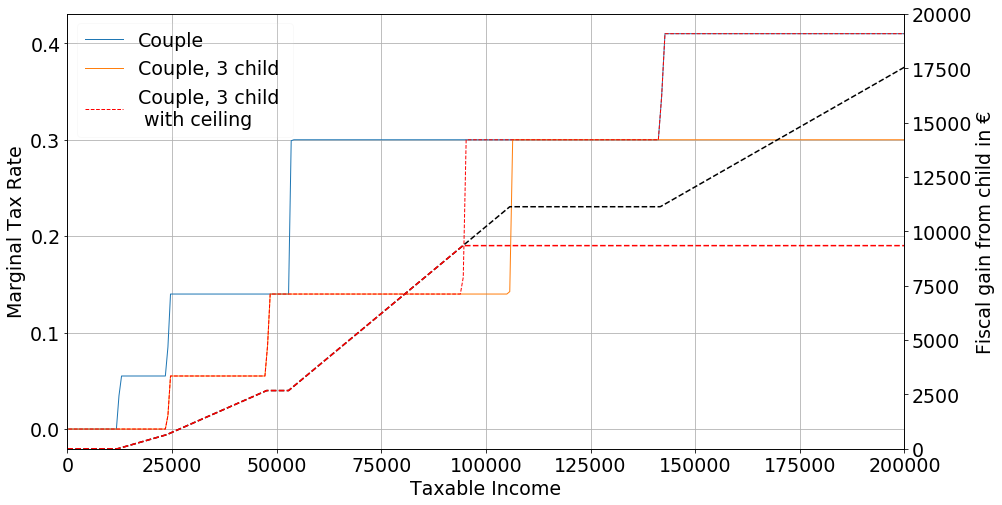

In [22]:
matplotlib.rc('font', size=19)
fig, ax1 = plt.subplots(figsize=(15,8))
ax2 = ax1.twinx()
smooth = 3
nb_enf = 0


 
#plt.legend(fontsize = 15, loc = 2)
#plt.ylim((0,.45))
ax1.grid()



for year in [2011]: 

    for nb_enf in [0]:

        
        keep = ax1.plot(simulation_dict[nb_enf][year].calculate_add("rbg",year)[::smooth][1:],
                1 -rates.marginal_rate(simulation_dict[nb_enf][year].calculate_add("ir_brut",year)[::smooth],
                   simulation_dict[nb_enf][year].calculate_add("rbg",year)[::smooth]),  
                  label = "Couple".format(year, nb_enf),
                 linewidth = 1)

        
    for nb_enf in [3,]:

        keep =  ax1.plot(simulation_dict[nb_enf][year].calculate_add("rbg",year)[::smooth][1:],
                1 -rates.marginal_rate(simulation_dict[nb_enf][year].calculate_add("ir_brut",year)[::smooth],
                   simulation_dict[nb_enf][year].calculate_add("rbg",year)[::smooth]),  
                  label =  "Couple, {} child".format(nb_enf),
                 linewidth = 1)
        ax1.plot(simulation_dict[nb_enf][year].calculate_add("rbg",year)[::smooth][1:],
                1 -rates.marginal_rate(simulation_dict[nb_enf][year].calculate_add("ir_plaf_qf",year)[::smooth],
                   simulation_dict[nb_enf][year].calculate_add("rbg",year)[::smooth]),  
                  label =  "Couple, {} child \n with ceiling".format(nb_enf),
                 linewidth = 1, color = "r", linestyle = "--")


        
        ax2.plot(simulation_dict[nb_enf][2011].calculate("rbg", period = 2011),
            simulation_dict[0][2011].calculate("ir_brut", period = 2011) - simulation_dict[nb_enf][2011].calculate("ir_brut", period = 2011),
                color = "k", linestyle = "--")
        ax2.plot(simulation_dict[1][2011].calculate("rbg", period = 2011),
            simulation_dict[nb_enf][2011].calculate("avantage_qf", period = 2011), color = "r", linestyle = "--")

        


ax1.set_xlabel("Taxable Income")
ax1.set_ylabel("Marginal Tax Rate"); ax2.set_ylabel(u"Fiscal gain from child in €")
ax1.legend(loc = 2, framealpha = 0.1)
plt.xlim(0, 200000)
ax2.set_ylim(0,20000)

A family of 3 children can have a child tax credit that is limited to 4*2336 (two half fiscal shares for the first two child, and a full share for the third child). The ceiling for the child tax credit is thus of 9334 euros.  

The impact consequence is that when the ceiling is reach, a family with 3 children "jump" on the MTR scheme of a couple without children.

### The Reform: 
#### The lowering of the family quotient ceiling.

The ceiling limiting the child tax credit has been lowered from 2336 euros in 2011, to 2000 euros in 2012, then to 15000 euros in 2013.

In [23]:
for year in range(2011,2014):
    print(year,":",
        empty_simulation.tax_benefit_system.parameters(periods.period(year)).impot_revenu.plafond_qf.general, 'euros'
    )

2011 : 2336.0 euros
2012 : 2000.0 euros
2013 : 1500.0 euros


#### Consequence of that lowering

###### Salaire net

In [24]:
df = pd.DataFrame()
for year in [2011,2013]:
    s = pd.Series()
    for nb_enf in range(1,7):
        gain = simulation_dict[nb_enf][year].calculate("avantage_qf", period = year)
        s = s.append(pd.Series(simulation_dict[nb_enf][year].calculate_add("salaire_net", period = year)[::2+nb_enf][np.where(gain<gain[-1])[0][-1]]))
    df[year] =s 
df.reset_index(inplace = True, drop = True);df.index.name = "Nb child" ; df.index = df.index+1 
df

,2011,2013
Nb child,,
1,"67,695.92188","62,615.69922"
2,"78,919.77344","67,996.39062"
3,"101,310.4922","79,206.20312"
4,"123,710.4922","90,212.78125"
5,"145,170.4375","101,424.1406"
6,"159,477.0156","112,386.3281"


##### Revenu brut global

In [25]:
df_rbg = pd.DataFrame()
for year in [2011,2013]:
    s = pd.Series()
    for nb_enf in range(1,7):
        gain = simulation_dict[nb_enf][year].calculate("avantage_qf", period = year)
        s = s.append(pd.Series(simulation_dict[nb_enf][year].calculate_add("rbg", period = year)[::][np.where(gain<gain[-1])[0][-1]]))
    df_rbg[year] = s 
df_rbg.reset_index(inplace = True, drop = True);df_rbg.index.name = "Nb child" ;
df_rbg

,2011,2013
Nb child,,
0,"63,083.75781","58,380.71484"
1,"73,539.80469","63,396.07031"
2,"94,343.875","73,844.17188"
3,"115,142.6875","84,095.07812"
4,"135,922.4062","94,508.8125"
5,"150,684.1875","104,691.375"


(0, 19000)

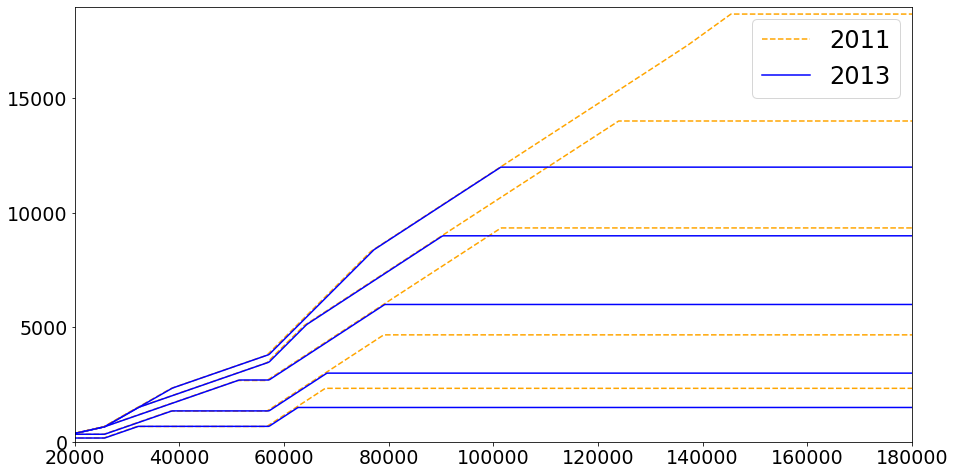

In [26]:
import seaborn as sns
fig = plt.figure(figsize=(15,8))

year_color = {2011:'orange', 2012:'r', 2013:'b'}
year_linestyle = {2011:'--', 2012:'r', 2013:'-'}
nb_enf = 1
for year in [2011,2013]:
    plt.plot(simulation_dict[nb_enf][year].calculate_add("salaire_net", period = year)[::2+nb_enf],
             simulation_dict[nb_enf][year].calculate("avantage_qf", period = year), label = year, linewidth = 1.5, color = year_color[year], linestyle = year_linestyle[year])
for nb_enf in range(2,6):
    for year in [2011,2013]:
        plt.plot(simulation_dict[nb_enf][year].calculate_add("salaire_net", period = year)[::2+nb_enf],
                 simulation_dict[nb_enf][year].calculate("avantage_qf", period = year), linewidth = 1.5, color = year_color[year], linestyle = year_linestyle[year])

#plugins.connect(fig, plugins.MousePosition(fontsize=24, fmt='.5g'))
#plt.title('QF advantage by year', fontsize = 24)
plt.legend(fontsize = 24)
plt.rcParams.update({'font.size': 32})
plt.xlim(20_000,180_000)
plt.ylim(0,19_000)
#mpld3.display()

No handles with labels found to put in legend.


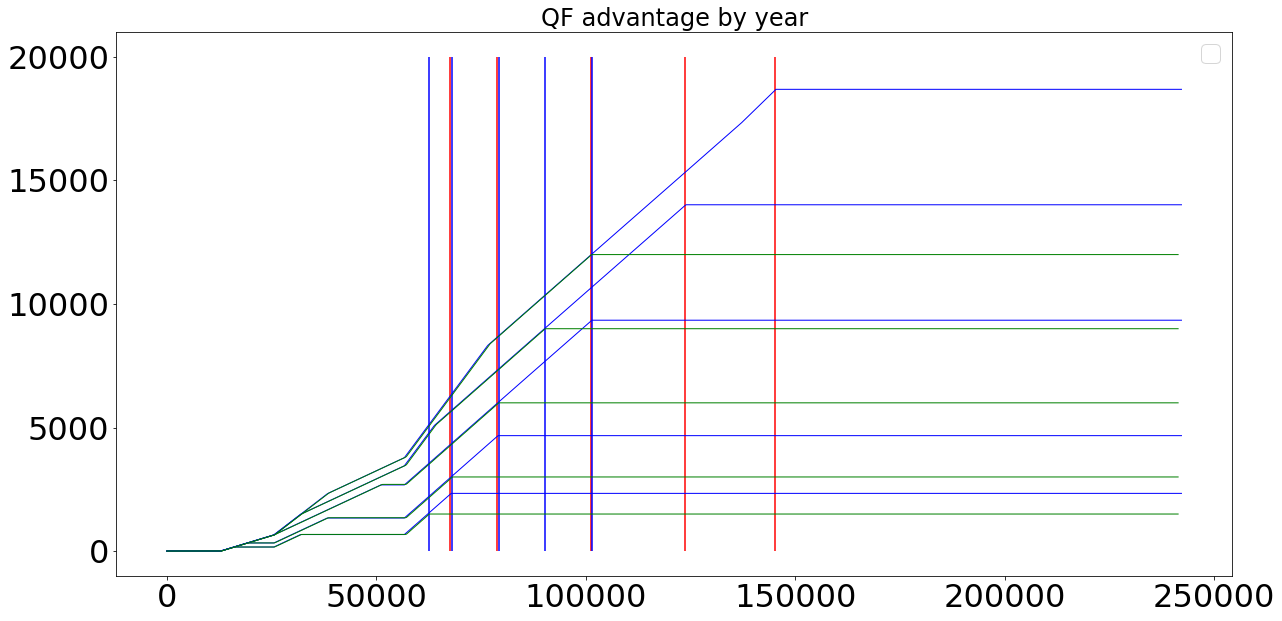

In [27]:
fig = plt.figure(figsize=(20,10))

year_color = {2011:'b', 2012:'r', 2013:'g'}
for nb_enf in range(1,6):
    for year in [2011,2013]:
        plt.plot(simulation_dict[nb_enf][year].calculate_add("salaire_net", period = year)[::2+nb_enf],
                 simulation_dict[nb_enf][year].calculate("avantage_qf", period = year), linewidth = 1, color = year_color[year])

#plugins.connect(fig, plugins.MousePosition(fontsize=24, fmt='.5g'))
plt.title('QF advantage by year', fontsize = 24)
plt.legend(fontsize = 24)
for val in df[2011].head(5): 
    plt.vlines(val, 0,20000, color = 'r')
for val in df[2013].head(5): 
    plt.vlines(val, 0,20000, color = 'b')
#mpld3.display()

#### Methodology

### The piecewize linear tax scheme

In [28]:
start_year = 2011 ; stop_year = 2016
empty_simulation = tax_benefit_system.new_scenario().new_simulation()
df = pd.DataFrame(index = range(40), columns= pd.MultiIndex.from_product([range(start_year,stop_year), ["Rate ($m$)", "Threshold ($\\beta$)"]]))
for year in range(start_year, stop_year):
    parameters = empty_simulation.tax_benefit_system.parameters(periods.period(year))
    df.loc[:,(year,"Rate ($m$)")] = pd.Series(parameters.impot_revenu.bareme.rates)
    df.loc[:,(year,"Threshold ($\\beta$)")] = pd.Series(parameters.impot_revenu.bareme.thresholds)
    pd.options.display.float_format = '{:20,.10g}'.format
    

df_piecewize_scheame = df
df_piecewize_scheame.dropna(axis=0, how='all', inplace = True) ; df_piecewize_scheame.replace(np.nan, "")#.style.set_properties(**{'text-align': 'right'})

2011                                      2012  \
            Rate ($m$)  Threshold ($\beta$)           Rate ($m$)   
0                    0                    0                    0   
1                0.055                5,963                0.055   
2                 0.14               11,896                 0.14   
3                  0.3               26,420                  0.3   
4                 0.41               70,830                 0.41   
5                                                           0.45   

                                       2013                       \
   Threshold ($\beta$)           Rate ($m$)  Threshold ($\beta$)   
0                    0                    0                    0   
1                5,963                0.055                6,011   
2               11,896                 0.14               11,991   
3               26,420                  0.3               26,631   
4               70,830                 0.41               71,397   
5              150,000                 0.45              151,200   

                  2014                                      2015  \
            Rate ($m$)  Threshold ($\beta$)           Rate ($m$)   
0                    0                    0                    0   
1                 0.14                9,690                 0.14   
2                  0.3               26,764                  0.3   
3                 0.41               71,754                 0.41   
4                 0.45              151,956                 0.45   
5                                                                  

                        
   Threshold ($\beta$)  
0                    0  
1                9,700  
2               26,791  
3               71,826  
4              152,108  
5

There is no big changes in the income tax scheme over the 2011-2015 period.

1. **A tax bracket has been added for income over 150 000 €**, but it only concerns married couple households

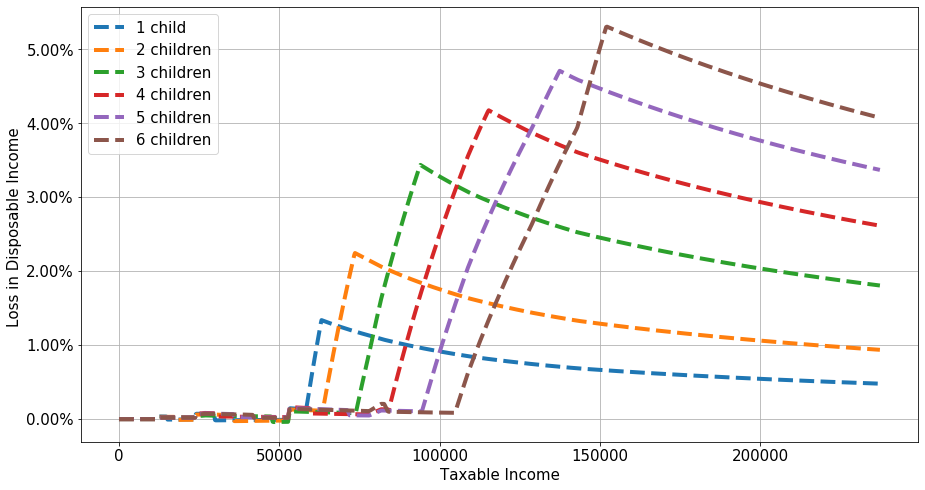

In [29]:
matplotlib.rc('font', size=15)
fig, ax1 = plt.subplots(figsize=(15,8))



for nb_enf in range(1,7):   

    relative_qf_gain_1 = (simulation_dict[nb_enf][2013].calculate("avantage_qf", period = 2013)/
             simulation_dict[nb_enf][2013].calculate_add("revenu_disponible", period = 2013))

    relative_qf_gain_2 = (simulation_dict[nb_enf][2011].calculate("avantage_qf", period = 2011)/
             simulation_dict[nb_enf][2011].calculate_add("revenu_disponible", period = 2011))
    perte_en_part_de_revdisp = ((simulation_dict[nb_enf][2011].calculate("avantage_qf", period = 2011) 
                                - (simulation_dict[nb_enf][2013].calculate("avantage_qf", period = 2013)))
                               /simulation_dict[nb_enf][2011].calculate_add("revenu_disponible", period = 2011))
    ax1.plot(simulation_dict[nb_enf][2013].calculate("rbg", period = 2013),
             perte_en_part_de_revdisp,
             label = "{} child".format(nb_enf)*(nb_enf==1)+"{} children".format(nb_enf)*(nb_enf>1),
             linewidth=4, linestyle = '--')
vals = ax1.get_yticks()
ax1.set_yticklabels(['{:3.2f}%'.format(x*100) for x in vals])
#plt.title('Change in child advantage vs last year in 2012 and 2013')
plt.xlabel("Taxable Income")
plt.ylabel("Loss in Disposable Income ")
plt.legend()
plt.grid()

